Initial Loss: {'train': tensor(3.2159, device='cuda:0'), 'val': tensor(3.2173, device='cuda:0')}
Epoch : 1  Training Loss: 0.9974708557128906  Validation Loss: 0.9985948801040649
Epoch : 2  Training Loss: 0.9682437777519226  Validation Loss: 0.9730552434921265
Epoch : 3  Training Loss: 0.954281747341156  Validation Loss: 0.9616865515708923
Epoch : 4  Training Loss: 0.9435551762580872  Validation Loss: 0.951602041721344
Epoch : 5  Training Loss: 0.9364596605300903  Validation Loss: 0.9471060633659363
Epoch : 6  Training Loss: 0.9314001798629761  Validation Loss: 0.9427293539047241
Epoch : 7  Training Loss: 0.9244637489318848  Validation Loss: 0.9377564787864685
Epoch : 8  Training Loss: 0.9212601184844971  Validation Loss: 0.9356294274330139
Epoch : 9  Training Loss: 0.9170432090759277  Validation Loss: 0.932498037815094
Epoch : 10  Training Loss: 0.914487361907959  Validation Loss: 0.9301024675369263
Epoch : 11  Training Loss: 0.9134801626205444  Validation Loss: 0.9297003746032715
Epo

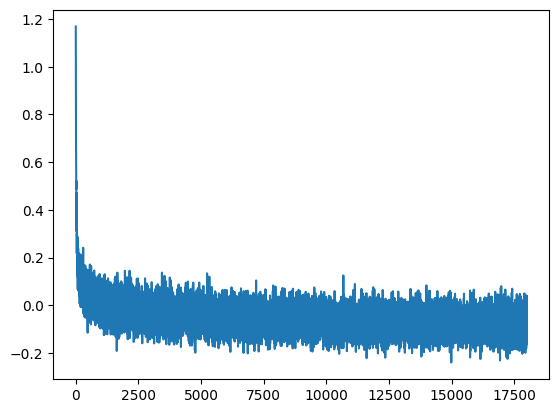

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

with open("/kaggle/input/namesdataset/names.txt",'r') as f:
    words = f.read().split('\n')


# hyper-parameters
vocab_size = 28
context_length = 16
n_emb = 32
n_layers = 3
n_heads = 4
dropout_ratio = 0.2         # reg
epochs = 20
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
alpha = 1e-3

torch.set_default_device('cuda')

# making the context length to be 16
words_modified = ['~' + w.lower() + (context_length - len(w))*'.' for w in words]

# mapping dictionaries
stoi = {chr(c):(c-97) for c in range(97,122+1)}
stoi['~'] = 26
stoi['.'] = 27
itos = {stoi[k]:k for k in stoi.keys()}


def encoder(l):
    ''' It will take a list of strings (words) and it will return a 2D list of each char encoded '''
    res = [list(el) for el in l]
    for i,el in enumerate(res):
        for j,ch in enumerate(el):
            res[i][j] = stoi[ch]
    
    return res


def decoder(l):
    ''' It will take a 2D list of int and decode it to a 1D list of strings '''
    res = []
    for el in l:
        w = ''.join(itos[ch] for ch in el)
        res.append(w)
    
    return res


data = encoder(words_modified)

n = 0.9

# shuffling data
np.random.shuffle(data)

ul = int(n*len(data))

data_train = data[:ul]
data_val = data[ul:]

# buidling the dataset
X_train = torch.tensor([el[:context_length] for el in data_train], device=device)
X_test = torch.tensor([el[:context_length] for el in data_val],device=device)
Y_train = torch.tensor([el[1:context_length + 1] for el in data_train],device=device)
Y_test = torch.tensor([el[1:context_length + 1] for el in data_val],device=device)


class SA_Head(nn.Module):
    
    ''' Self Attention Head '''
    
    def __init__(self,head_size):

        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(n_emb,self.head_size, bias=False)
        self.key = nn.Linear(n_emb,self.head_size, bias=False)
        self.value = nn.Linear(n_emb,self.head_size, bias=False)
        self.dropout = nn.Dropout(dropout_ratio)
        

    def forward(self,x):

        # x: B x T x C  (B: number of batches, T: context_length, C: number of emb, H: head_size)

        # B x T x H
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        att = q @ k.transpose(-2,-1)      # B x T x T
        att *= (self.head_size**-0.5)     # normalization

        # decoder transformer
        T = x.shape[1]
        tril_temp = torch.tril(torch.ones(T,T))
        att = att.masked_fill(tril_temp==0,float('-inf'))
        
        att = F.softmax(att,dim=-1)
        
        att = self.dropout(att)
        
        res = att @ v    # B x T x H

        return res



class MultipleSA_Head(nn.Module):

    ''' Muliple SA heads'''

    def __init__(self,n_heads,n_emb):

        super().__init__()
        self.head_size = n_emb // n_heads
        self.heads = nn.ModuleList([SA_Head(self.head_size) for _  in range(n_heads)])
        # because of residual connections
        self.proj = nn.Linear(n_emb,n_emb)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self,x):

        # x: B x T x C
        res = torch.cat([head(x) for head in self.heads],dim=-1)
        res = self.proj(res)
        res = self.dropout(res)

        return res
        

class FeedForward(nn.Module):

    ''' Computation Part'''

    def __init__(self, n_emb):

        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_emb, 4*n_emb),
            nn.ReLU(),
            nn.Linear(4 * n_emb, n_emb),
            nn.Dropout(dropout_ratio)
        )

    def forward(self,x):

        res = self.mlp(x)
        return res


class Block(nn.Module):

    '''Block of Communication and Computation'''

    def __init__(self,n_emb,n_heads):
        
        assert n_emb % n_heads == 0, "n_emb % n_heads should be 0"

        super().__init__()

        self.ln1 = nn.LayerNorm(n_emb)
        self.sa_heads = MultipleSA_Head(n_heads,n_emb)
        self.ln2 = nn.LayerNorm(n_emb)
        self.feed_fwd = FeedForward(n_emb)

    def forward(self,x):

        x = x + self.sa_heads(self.ln1(x))      # residual connections
        x = x + self.feed_fwd(self.ln2(x))      # residual connections

        return x
        

class LanguageModel(nn.Module):

    ''' Transformer model'''
    def __init__(self):

        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, n_emb, device=device)
        self.pos_emb = nn.Embedding(context_length, n_emb, device=device)
        self.blocks = nn.Sequential(*[Block(n_emb,n_heads) for _ in range(n_layers)])
        self.ln1 = nn.LayerNorm(n_emb)
        self.linear_head = nn.Linear(n_emb,vocab_size)

    def forward(self,x,y = None):

        # x: B x T

        B, T = x.shape

        tok = self.token_emb(x)                 # B x T x C
        pos = self.pos_emb(torch.arange(T))     # T X C
        res = tok + pos                         # B x T x C
        res = self.blocks(res)
        res = self.ln1(res)
        logits = self.linear_head(res)         # B x T x V

        if not y == None:
            # converting to 2D arrays
            logits_mod = logits.view((B*T),-1)
            y_mod = y.view(-1)
            loss = F.cross_entropy(logits_mod,y_mod)
        else:
            loss = None
            
        return logits, loss

    def generate(self,x):

        # x: B x T
        # B: number of names it wants
        # _  starting contexts: maybe empty (0-15)

        t = x.shape[1] 
        
        assert t < 17, "Context Length Exceeded"

        for i in range(context_length - t + 1):      # t:max -> 17
            logits, _ = self.forward(x)
            logits = logits[:,-1,:]      #(B,V)
            probs = F.softmax(logits,dim=-1)
            # return indices
            next_char = torch.multinomial(probs,num_samples=1)   #(B,1)
            x = torch.cat((x,next_char),dim=1)

        return x
        
model = LanguageModel()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=alpha)   # decay: 0.1

# overall loss estimator
@torch.no_grad()
def get_loss():

    model.eval()    # turns on evaluation mode of the model
    losses = {}
    _, losses['train'] = model(X_train,Y_train)
    _, losses['val'] = model(X_test,Y_test)
    model.train()   # turns on training mode of the model

    return losses

print("Initial Loss:",get_loss())

loss_hist=[]

# Training
for i in range(epochs):

    # mini - batching
    idx = np.arange((Y_train.shape[0]))
    num_iter = Y_train.shape[0]//batch_size
    np.random.shuffle(idx)

    for j in range(num_iter):

        Xb = X_train[idx[j*batch_size:(j+1)*batch_size]]
        Yb = Y_train[idx[j*batch_size:(j+1)*batch_size]]

        # forward pass
        logits, loss = model(Xb,Yb)
        loss_hist.append(loss.item())

        # backward pass
        loss.backward()

        # step
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    # after every epoch
    losses = get_loss()
    print(f"Epoch : {i+1}  Training Loss: {losses['train'].item()}  Validation Loss: {losses['val'].item()}")

loss_hist_plot = np.log(loss_hist)
plt.plot(loss_hist_plot)

torch.save(model.state_dict(),'transformer.pth')